# Churn Prediction

### Import Libraries and dataset

In [64]:
import numpy as np # linear algebra
from scipy import stats # statistic library
import pandas as pd # To table manipulations
import seaborn as sns
import matplotlib.pyplot as plt

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

import os

#Importing the auxiliar and preprocessing librarys 
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

#Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding


In [14]:
df = pd.read_csv("/Users/mellie/Documents/DS project/BankChurn/BankChurners.csv")
df.head(3)
df["Attrition_Flag"] = df["Attrition_Flag"].apply(lambda x:1 if x =="Attrited Customer" else 0)

In [16]:
df = df.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', axis = 1)
df = df.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', axis = 1)

In [17]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2) 

    return summary

resumetable(df)

Dataset Shape: (10127, 21)


Name   dtypes  Missing  Uniques  First Value  \
0                  CLIENTNUM    int64        0    10127    768805383   
1             Attrition_Flag    int64        0        2            0   
2               Customer_Age    int64        0       45           45   
3                     Gender   object        0        2            M   
4            Dependent_count    int64        0        6            3   
5            Education_Level   object        0        7  High School   
6             Marital_Status   object        0        4      Married   
7            Income_Category   object        0        6  $60K - $80K   
8              Card_Category   object        0        4         Blue   
9             Months_on_book    int64        0       44           39   
10  Total_Relationship_Count    int64        0        6            5   
11    Months_Inactive_12_mon    int64        0        7            1   
12     Contacts_Count_12_mon    int64        0        7            3   
13              Credit_Limit  float64        0     6205      12691.0   
14       Total_Revolving_Bal    int64        0     1974          777   
15           Avg_Open_To_Buy  float64        0     6813      11914.0   
16      Total_Amt_Chng_Q4_Q1  float64        0     1158        1.335   
17           Total_Trans_Amt    int64        0     5033         1144   
18            Total_Trans_Ct    int64        0      126           42   
19       Total_Ct_Chng_Q4_Q1  float64        0      830        1.625   
20     Avg_Utilization_Ratio  float64        0      964        0.061   

      Second Value   Third Value  Entropy  
0        818770008     713982108     4.01  
1                0             0     0.19  
2               49            51     1.51  
3                F             M     0.30  
4                5             3     0.72  
5         Graduate      Graduate     0.77  
6           Single       Married     0.48  
7   Less than $40K  $80K - $120K     0.72  
8             Blue          Blue     0.13  
9               44            36     1.41  
10               6             4     0.76  
11               1             1     0.58  
12               2             0     0.66  
13          8256.0        3418.0     3.53  
14             864             0     2.60  
15          7392.0        3418.0     3.70  
16           1.541         2.594     2.86  
17            1291          1887     3.62  
18              33            20     1.95  
19           3.714         2.333     2.66  
20           0.105           0.0     2.43

#### From the table:
* Clientnum is the identifier
* No missing values
* Some categorical features

In [5]:
cate_cols = ["Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]
nume_cols = [x for x in list(df.iloc[:, 2:20].columns) if x not in cate_cols]

In [6]:
print("CUSTOMERS %CHURN:")
print(round(df['Attrition_Flag'].value_counts(normalize=True) * 100,2))

CUSTOMERS %CHURN:
0    83.93
1    16.07
Name: Attrition_Flag, dtype: float64


There are 16% churn customers in our dataset, compared to nearly 84% of existing customers. 
Hypothesis about churn customers and test results:

* Churn customer has lower total transaction amount (approved) and lower number of transactions in the last 12 months (approved). Correlation of these two features with churn rate indicating that, frequency of transactions is more related to churn decision than the amount of transaction.
* Change in amount and number of transaction (Q4 - Q1) is related to churn. Again, the number of transactions shows higher correlation. 
* Churn customer has lower revolving balance (approved). Although higher balance (over 700) has lower churn rate, churner number of 600-2500 balance is steadily, thus, we must investigate why they churn when maintaining high balance in the year. Solutions must address how to retain high-balance customers, rather than how to increase balance.
* Churn customer uses less products than loyal customers (approved). Customers use less than 3 products have significantly higher churn rate.

* Gender and Income Level have significant relation with Churn
* Churn customer does not satisfy with one particular type of card (rejected - no evidence to conclude)
* Churn customer has shorter tenure (Months on book) (rejected - no evidence to conclude)

==> Actionable campaigns to target churning customers will focus on:
(1) initiate transactions (target 60) 
(2) use more products (target 3)
(3) increase transaction amount


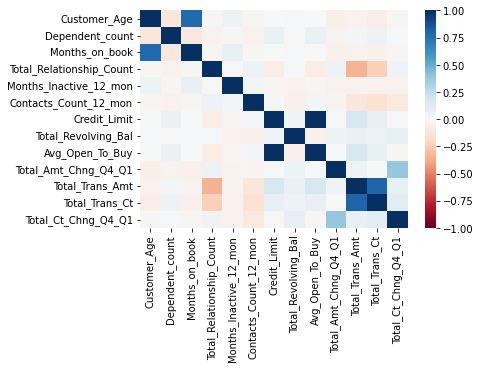

Now let's check churn rate of categorical variables.

Two categorical variables have significant association with churn are Gender and Income Level.

In [9]:
from scipy.stats import chi2_contingency

for i, predictor in enumerate(df[cate_cols]):
    # Create a contingency table
    contingency_table = pd.crosstab(df[predictor], df['Attrition_Flag'])

    # Perform chi-square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

    if p_val < 0.05:
        print('[{}]'.format(predictor))
        print('Chi-square statistic:', round(chi2_stat, 3))
        print('P-value:', round(p_val, 3))

[Gender]
Chi-square statistic: 13.866
P-value: 0.0
[Income_Category]
Chi-square statistic: 12.832
P-value: 0.025


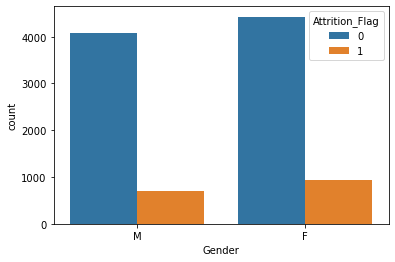

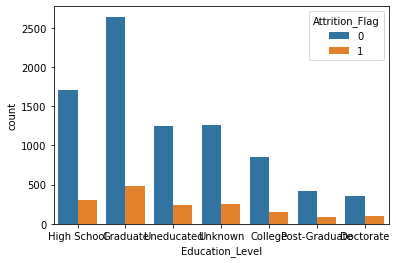

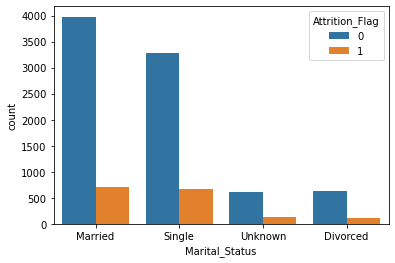

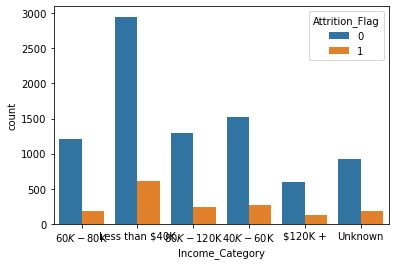

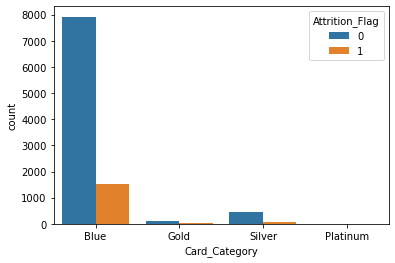

In [28]:
for i, predictor in enumerate(df[cate_cols]):
    plt.figure(i)
    sns.countplot(data=df, x=predictor, hue='Attrition_Flag')
    
# ax = sns.countplot(x= df["Attrition_Flag"], palette= cols)
# ax.bar_label(ax.containers[0])

Numerical variables have some high correlation.
(1) Months on book vs. Customer Age
(2) Credit Limit vs. Average Open to buy
(3) Total transaction Amount vs. Total transaction count

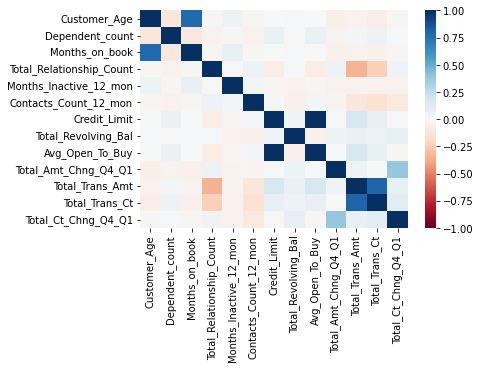

In [44]:
plt.figure(1)
corr = df[nume_cols].corr()
corr_nume = sns.heatmap(corr, fmt=".2f", cmap="RdBu", center = 0, vmin = -1, vmax = 1)

We will look into the highly correlated pairs in numerical variables to see if we should remove some of the features before building model to avoid multi-collinearity.
(1) Credit Limit and Average Open to buy are highly corelated with each other, however, having little correlation with churn outcome. Thus we will remove Avg Open to buy as this feature has lower correlation with churn.
(2) Months on book and Customer Age are highly correlated but having little correlation with churn. We will remove either of features, and Months on book will be removed before model development.
(3) Transaction Amount and Transaction Count are highly correlated with the churn outcome, however, they are moderately correlated with each other. We will keep both to see if removing is needed.

Text(0, 0.5, 'Avg_Open_To_Buy')

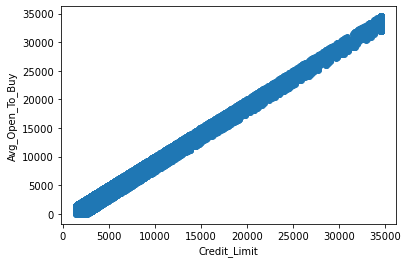

In [19]:
# exploring the correlated features
plt.scatter(df['Credit_Limit'], df['Avg_Open_To_Buy'])
plt.xlabel('Credit_Limit')
plt.ylabel('Avg_Open_To_Buy') 

Text(0, 0.5, 'Customer_Age')

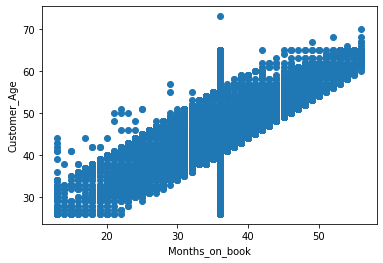

In [30]:
plt.scatter(df['Months_on_book'], df['Customer_Age'])
plt.xlabel('Months_on_book')
plt.ylabel('Customer_Age') 

Text(0, 0.5, 'Total_Trans_Amt')

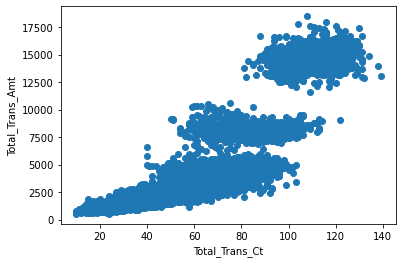

In [32]:
plt.scatter(df['Total_Trans_Ct'], df['Total_Trans_Amt'])
plt.xlabel('Total_Trans_Ct')
plt.ylabel('Total_Trans_Amt') 

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

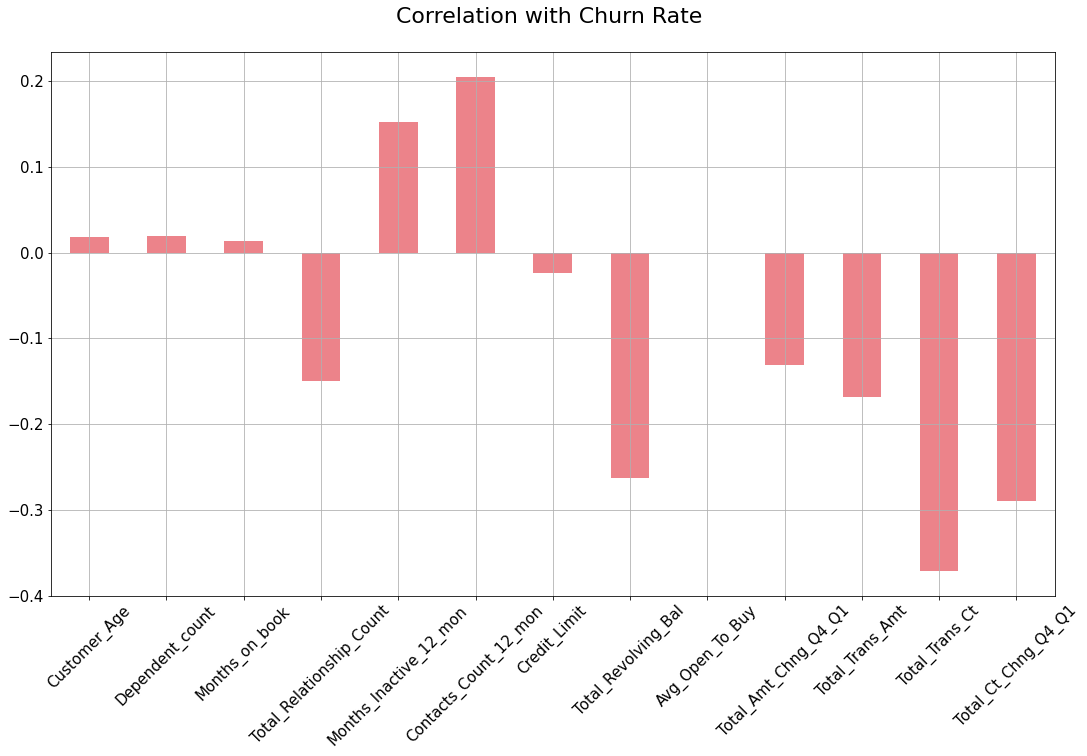

In [11]:
# Correlation of numerical variables with churn
df2 = df[nume_cols]
correlations = df2.corrwith(df.Attrition_Flag)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = '#ec838a',
        rot = 45, grid = True)
plt.title('Correlation with Churn Rate \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

In [12]:
# Hypothesis testing what feature that churners and remainers are significantly different
from scipy.stats import ttest_ind

for i, predictor in enumerate(df[nume_cols]):
    # Split the DataFrame into churn and no churn groups
    churn_group = df.loc[df['Attrition_Flag'] == 1, predictor]
    no_churn_group = df.loc[df['Attrition_Flag'] == 0, predictor]

    # Perform a two-sample t-test
    t_statistic, p_value = ttest_ind(churn_group, no_churn_group)

    if p_value < 0.05:
        # Print the results
        print('[{}]'.format(predictor), 'mean churn group:', round(churn_group.mean()), 'mean no churn', round(no_churn_group.mean()))
        

[Total_Relationship_Count] mean churn group: 3 mean no churn 4
[Months_Inactive_12_mon] mean churn group: 3 mean no churn 2
[Contacts_Count_12_mon] mean churn group: 3 mean no churn 2
[Credit_Limit] mean churn group: 8136 mean no churn 8727
[Total_Revolving_Bal] mean churn group: 673 mean no churn 1257
[Total_Amt_Chng_Q4_Q1] mean churn group: 1 mean no churn 1
[Total_Trans_Amt] mean churn group: 3095 mean no churn 4655
[Total_Trans_Ct] mean churn group: 45 mean no churn 69
[Total_Ct_Chng_Q4_Q1] mean churn group: 1 mean no churn 1


In [13]:
for i, predictor in enumerate(df[nume_cols]):
    x1=df[df["Attrition_Flag"]==0][predictor]
    x2=df[df["Attrition_Flag"]==1][predictor]
    hist_data = [x1,x2]

    group_labels = ['Not Churn','Churn']
    colors = ['#DC3912', '#FFA15A']

    # Create distplot with curve_type set to 'normal'
    distplot1 = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

    # Add title
    distplot1.update_layout(title_text=df[predictor].name)
    distplot1.update_xaxes(title_text=df[predictor].name)
    distplot1.update_yaxes(title_text='Density')
    distplot1.show()

In [40]:
# make gender numerical
df['Gender'] = df['Gender'].map({'M': 1, 'F': 0})

# drop client id
df = df.drop('CLIENTNUM', axis = 1)

# one-hot encoding on categorical columns
df = pd.get_dummies(df, columns = cate_cols)

# minmax scaling numeric features 
for col in df[nume_cols]:
    df[col] = MinMaxScaler().fit_transform(df[[col]])


In [42]:
# split into X and y
y = df['Attrition_Flag']
X = df.drop('Attrition_Flag', axis = 1)


Feature selection

We will single out the most relevant features

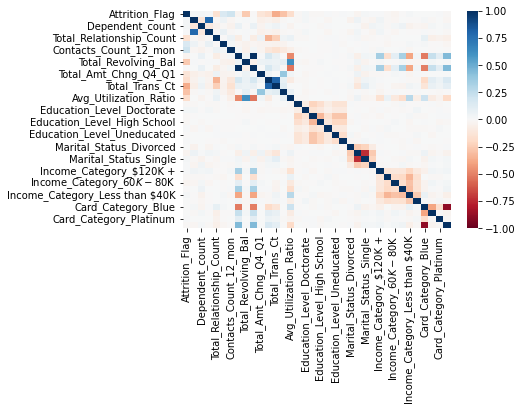

In [45]:
plt.figure(1)
corr2 = df.corr()
corr2_nume = sns.heatmap(corr2, fmt=".2f", cmap="RdBu", center = 0, vmin = -1, vmax = 1)

In [48]:
print("Correlation Coefficient of all the Features")
corr2.sort_values(["Attrition_Flag"], ascending = False, inplace = True)
correlations = corr2.Attrition_Flag
a = correlations[correlations > 0.1]
b = correlations[correlations < -0.1]
top_corr_features = a.append(b)
top_corr_features

Correlation Coefficient of all the Features


/var/folders/1m/zr9xdtwj63z8sytn7dt7crmh0000gn/T/ipykernel_3489/1186407652.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Attrition_Flag              1.000000
Contacts_Count_12_mon       0.204491
Months_Inactive_12_mon      0.152449
Total_Amt_Chng_Q4_Q1       -0.131063
Total_Relationship_Count   -0.150005
Total_Trans_Amt            -0.168598
Avg_Utilization_Ratio      -0.178410
Total_Revolving_Bal        -0.263053
Total_Ct_Chng_Q4_Q1        -0.290054
Total_Trans_Ct             -0.371403
Name: Attrition_Flag, dtype: float64

In [49]:
# Code adapted from: https://www.kaggle.com/code/andreshg/churn-prediction-0-99-auc-h2o-sklearn-smote#4.-Feature-Selection

def plot_importances(model, model_name, features_to_plot, feature_names):
    #fit model and performances
    model.fit(X,y)
    importances = model.feature_importances_
    
    # sort and rank importances
    indices = np.argsort(importances)
    best_features = np.array(feature_names)[indices][-features_to_plot:]
    values = importances[indices][-features_to_plot:]
    
    # plot a graph
    y_ticks = np.arange(0, features_to_plot)
    fig, ax = plt.subplots()
    ax.barh(y_ticks, values, color = '#b2c4cc')
    ax.set_yticklabels(best_features)
    ax.set_yticks(y_ticks)
    ax.set_title("%s Feature Importances"%(model_name))
    fig.tight_layout()
    plt.show()
    
def best_features(model, features_to_plot, feature_names):
    # get list of best features 
    model.fit(X,y)
    importances = model.feature_importances_

    indices = np.argsort(importances)
    best_features = np.array(feature_names)[indices][-features_to_plot:]
    return best_features

/var/folders/1m/zr9xdtwj63z8sytn7dt7crmh0000gn/T/ipykernel_3489/186213632.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



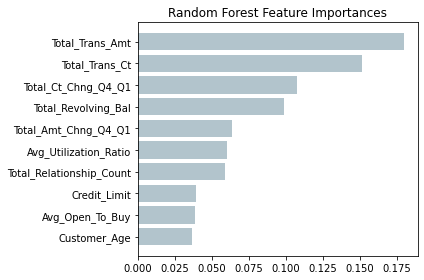

/var/folders/1m/zr9xdtwj63z8sytn7dt7crmh0000gn/T/ipykernel_3489/186213632.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



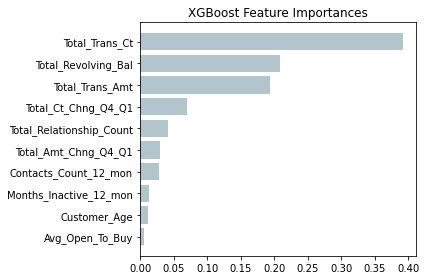

/var/folders/1m/zr9xdtwj63z8sytn7dt7crmh0000gn/T/ipykernel_3489/186213632.py:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



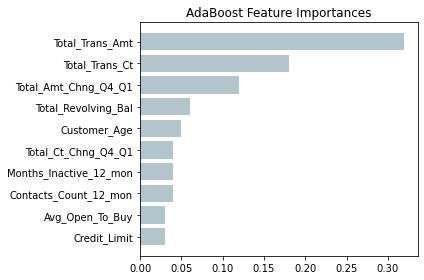

In [52]:
feature_names = list(X.columns)

model1 = RandomForestClassifier(random_state = 1234)
plot_importances(model1, 'Random Forest', 10, feature_names)

model2 = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)
plot_importances(model2, 'XGBoost', 10, feature_names)

model3 = AdaBoostClassifier(n_estimators = 100, learning_rate = 1.0, random_state = 0)
plot_importances(model3, 'AdaBoost', 10, feature_names)

In [55]:
# looking at the F-value between label/feature for classification tasks
f_selector = SelectKBest(f_classif, k = 10)
f_selector.fit_transform(X, y)
f_selector_best = f_selector.get_feature_names_out()
print(f_selector_best)

['Total_Relationship_Count' 'Months_Inactive_12_mon'
 'Contacts_Count_12_mon' 'Total_Revolving_Bal' 'Total_Amt_Chng_Q4_Q1'
 'Total_Trans_Amt' 'Total_Trans_Ct' 'Total_Ct_Chng_Q4_Q1'
 'Avg_Utilization_Ratio' 'Education_Level_Doctorate']


In [56]:
# best components
forest_best = list(best_features(model1, 10, feature_names))
XG_best = list(best_features(model2, 10, feature_names))
ada_best = list(best_features(model3, 10, feature_names))
top_corr_features = list(top_corr_features.index[1:])
f_selector_best = list(f_selector_best)

In [60]:
best_features_overall = forest_best + XG_best + ada_best + top_corr_features + f_selector_best

# create a dictionary with the number of times features appear 
from collections import Counter
count_best_features = dict(Counter(best_features_overall))

# list of the features without any repeatitions
features_no_repeats = list(dict.fromkeys(best_features_overall))

# get list of features with high counts in the dictionary
def get_features(threshold):
    # remove features below a certain number of appearances
    chosen_features = []
    for i in features_no_repeats:
        if count_best_features[i] > threshold:
            chosen_features.append(i)
    return chosen_features

['Customer_Age',
 'Total_Relationship_Count',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Revolving_Bal',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Trans_Ct',
 'Total_Trans_Amt',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon']

In [70]:
# run ranges of possible thresholds
for i in range(0,5):
   eval_model(model1, 'forest', X, y, i)
    
for i in range(0,5):
   eval_model(model2, 'XGBoost', X, y, i)

for i in range(0,5):
   eval_model(model3, 'AdaBoost', X, y, i)

[[2089   24]
 [  67  352]] forest model with 0 threshold: 0.8855 F1-score and 0.9641 accuracy
[[2090   23]
 [  70  349]] forest model with 1 threshold: 0.8824 F1-score and 0.9633 accuracy
[[2092   21]
 [  66  353]] forest model with 2 threshold: 0.8903 F1-score and 0.9656 accuracy
[[2084   29]
 [  68  351]] forest model with 3 threshold: 0.8786 F1-score and 0.9617 accuracy
[[2063   50]
 [  85  334]] forest model with 4 threshold: 0.8319 F1-score and 0.9467 accuracy
[[2076   37]
 [  69  350]] XGBoost model with 0 threshold: 0.8685 F1-score and 0.9581 accuracy
[[2076   37]
 [  69  350]] XGBoost model with 1 threshold: 0.8685 F1-score and 0.9581 accuracy
[[2074   39]
 [  64  355]] XGBoost model with 2 threshold: 0.8733 F1-score and 0.9593 accuracy
[[2073   40]
 [  78  341]] XGBoost model with 3 threshold: 0.8525 F1-score and 0.9534 accuracy
[[2064   49]
 [  96  323]] XGBoost model with 4 threshold: 0.8167 F1-score and 0.9427 accuracy
[[2080   33]
 [  65  354]] AdaBoost model with 0 thresh

In [66]:
# for RF and XGBoost, threshold is 2, AdaBoost is 1
chosen_features = get_features(2)
chosen_features.remove('Avg_Open_To_Buy')
chosen_features.remove('Avg_Utilization_Ratio')
chosen_features

['Customer_Age',
 'Total_Relationship_Count',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Revolving_Bal',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Trans_Ct',
 'Total_Trans_Amt',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon']

In [67]:
# find the best threshold for features
def eval_model(model, model_name, X, y, threshold):
    # make X the chosen subset
    chosen_features = get_features(threshold)
    X = X[chosen_features]
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    # fit model
    model.fit(train_x,train_y)
    model.score(test_x, test_y)
    pred_test = model.predict(test_x)
    
    # get metrics
    f1 = metrics.f1_score(test_y, pred_test)
    test_acc = metrics.accuracy_score(test_y, pred_test)
    con = metrics.confusion_matrix(test_y, pred_test)
    
    print(con,'%s model with %s threshold: %.4f F1-score and %.4f accuracy'%(model_name, threshold, f1, test_acc))

In [68]:
# full dataset
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
model1.fit(train_x,train_y)
model1.score(test_x, test_y)
pred_test = model1.predict(test_x)
    
f1 = metrics.f1_score(test_y, pred_test)
test_acc = metrics.accuracy_score(test_y, pred_test)
con = metrics.confusion_matrix(test_y, pred_test)
    
print(con,f1,test_acc)

[[2090   23]
 [ 110  309]] 0.8229027962716378 0.9474723538704581


In [69]:
### reduced dataset
Xnew = X[chosen_features]

train_x, test_x, train_y, test_y = train_test_split(Xnew, y, test_size = 0.25, random_state = 42)
    
model1.fit(train_x,train_y)
model1.score(test_x, test_y)
pred_test = model1.predict(test_x)
    
f1 = metrics.f1_score(test_y, pred_test)
test_acc = metrics.accuracy_score(test_y, pred_test)
con = metrics.confusion_matrix(test_y, pred_test)
    
print(con,f1,test_acc)

[[2079   34]
 [  61  358]] 0.8828606658446362 0.9624802527646129


Model selection
From the run test, random forest performed the best so we will hypertune these parameters

In [71]:
# lists of possible parameters
n = [400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
depth = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
rand = [600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250]

forest = RandomForestClassifier(n_estimators = 100, max_depth = 15, random_state = 750)
eval_model(forest, 'forest', X, y, 2)

[[2089   24]
 [  66  353]] forest model with 2 threshold: 0.8869 F1-score and 0.9645 accuracy


In [72]:
def eval_forest(model, model_name, X, y, threshold, n, depth, rand):
    # create subset from feature selection
    chosen_features = get_features(threshold)
    chosen_features.remove('Avg_Open_To_Buy')
    chosen_features.remove('Avg_Utilization_Ratio')
    X = X[chosen_features]
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 42)
    
    model.fit(train_x,train_y)
    model.score(test_x, test_y)
    pred_test = model.predict(test_x)
    
    f1 = metrics.f1_score(test_y, pred_test)
    test_acc = metrics.accuracy_score(test_y, pred_test)
    con = metrics.confusion_matrix(test_y, pred_test)
    
    print('Model: %s Threshold: %s F1-Score %.4f Accuracy: %.4f n_estimators: %s depth: %s rand: %s'%(model_name, threshold, f1, test_acc,n,depth,rand))

In [73]:
# run for loops for each parameter and carry forward the best one 
for i in n:
   forest = RandomForestClassifier(n_estimators = i, max_depth = 10, random_state = 750)
   eval_forest(forest, 'forest', X, y, 2, i, 10, 750)

Model: forest Threshold: 2 F1-Score 0.8883 Accuracy: 0.9648 n_estimators: 400 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8869 Accuracy: 0.9645 n_estimators: 450 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8855 Accuracy: 0.9641 n_estimators: 500 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8855 Accuracy: 0.9641 n_estimators: 550 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8869 Accuracy: 0.9645 n_estimators: 600 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8855 Accuracy: 0.9641 n_estimators: 650 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8855 Accuracy: 0.9641 n_estimators: 700 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8883 Accuracy: 0.9648 n_estimators: 750 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8883 Accuracy: 0.9648 n_estimators: 800 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8883 Accuracy: 0.9648 n_estimators: 850 depth: 10 rand: 750
Model: forest Thresh

In [75]:
for i in depth:
   forest = RandomForestClassifier(n_estimators = 850, max_depth = i, random_state = 750)
   eval_forest(forest, 'forest', X, y, 2, 850, i, 750) 

Model: forest Threshold: 2 F1-Score 0.8590 Accuracy: 0.9566 n_estimators: 850 depth: 8 rand: 750
Model: forest Threshold: 2 F1-Score 0.8731 Accuracy: 0.9605 n_estimators: 850 depth: 9 rand: 750
Model: forest Threshold: 2 F1-Score 0.8883 Accuracy: 0.9648 n_estimators: 850 depth: 10 rand: 750
Model: forest Threshold: 2 F1-Score 0.8861 Accuracy: 0.9641 n_estimators: 850 depth: 11 rand: 750
Model: forest Threshold: 2 F1-Score 0.8889 Accuracy: 0.9648 n_estimators: 850 depth: 12 rand: 750
Model: forest Threshold: 2 F1-Score 0.8889 Accuracy: 0.9648 n_estimators: 850 depth: 13 rand: 750
Model: forest Threshold: 2 F1-Score 0.8917 Accuracy: 0.9656 n_estimators: 850 depth: 14 rand: 750
Model: forest Threshold: 2 F1-Score 0.8933 Accuracy: 0.9660 n_estimators: 850 depth: 15 rand: 750
Model: forest Threshold: 2 F1-Score 0.8917 Accuracy: 0.9656 n_estimators: 850 depth: 16 rand: 750
Model: forest Threshold: 2 F1-Score 0.8939 Accuracy: 0.9664 n_estimators: 850 depth: 17 rand: 750
Model: forest Threshol

Based on the F1-score and Accuracy, the optimal n_estimators = 400 (rule of simplicity) and depth = 17

In [77]:
forest = RandomForestClassifier(n_estimators = 400, max_depth = 17, random_state = 750)

In [79]:
train_x, test_x, train_y, test_y = train_test_split(Xnew, y, test_size = 0.25, random_state = 42)
    
forest.fit(train_x,train_y)
forest.score(test_x, test_y)
pred_test = forest.predict(test_x)
    
f1 = metrics.f1_score(test_y, pred_test)
test_acc = metrics.accuracy_score(test_y, pred_test)
con = metrics.confusion_matrix(test_y, pred_test)
precision = metrics.precision_score(test_y, pred_test)
recall = metrics.recall_score(test_y, pred_test)
roc = metrics.roc_auc_score(test_y, pred_test)

In [80]:
print('Accuracy Score', test_acc)
print('Precision', precision)
print('Recall', recall)
print('F1-Score', f1)
print('ROC Score', roc)
print(con)

Accuracy Score 0.9660347551342812
Precision 0.9302325581395349
Recall 0.8591885441527446
F1-Score 0.8933002481389578
ROC Score 0.9232052517261593
[[2086   27]
 [  59  360]]


In [82]:
#cross validation
cv_results = cross_validate(forest, Xnew, y, scoring = ('f1', 'accuracy', 'roc_auc'), cv = 8)
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_roc_auc']

In [83]:
cv_results

{'fit_time': array([5.03008199, 4.87416506, 5.0092628 , 5.08638692, 5.12611628,
        5.23983097, 4.82476211, 5.04653406]),
 'score_time': array([0.17312098, 0.19174504, 0.18156719, 0.16328788, 0.15662098,
        0.15780187, 0.15108681, 0.131567  ]),
 'test_f1': array([0.60416667, 0.82808717, 0.88674699, 0.88431877, 0.89487871,
        0.921875  , 0.79126214, 0.73469388]),
 'test_accuracy': array([0.87993681, 0.94391785, 0.9628752 , 0.96445498, 0.96919431,
        0.97630332, 0.93206951, 0.92806324]),
 'test_roc_auc': array([0.9085009 , 0.967167  , 0.98625277, 0.99159364, 0.99562885,
        0.99790905, 0.89737731, 0.91049743])}